In [1]:
import sys
sys.path.insert(0,'..')

from expander import get_cayley_graph, cayley_size, get_suitable_cayley_n, get_cayley_graph_breadth_first, get_undirected_cayley_graph_ordered_adj, get_edge_index_from_adj, index_of_tensor
from math import sqrt
import matplotlib.pyplot as plt
from netgraph import Graph, InteractiveGraph
import numpy as np
import networkx as nx
from matplotlib import patches
import torch

In [6]:
def get_layer_positions(layer, n, tot_n):
    y = float(n)/(tot_n - 1)
    mult = sqrt(y)
    if mult/len(layer) > 0.4:
        mult = (len(layer) - 1) * 0.4
    x_min, x_max = 0.5 - mult*0.5, 0.5 + mult*0.5
    x_jump = (x_max - x_min)/(len(layer) - 1) if len(layer) > 1 else 0

    return [np.array([x_min + x_jump * i,  1 - y]) for i in range(len(layer))]

def mat_to_label(mat):
    # f"|{mat[0][0]} {mat[0][1]}|\n|{mat[1][0]} {mat[1][1]}|"
    return r"$\quad \left[ \matrix{{ \mathbf{{{0}}} & \mathbf{{{1}}} \cr \mathbf{{{2}}} & \mathbf{{{3}}} \cr}} \right]$".format(mat[0][0], mat[0][1], mat[1][0], mat[1][1])

def get_node_positions_and_labels(breadth_first_nodes, layers):
    positions = []
    labels = []
    orig_indices = []
    for i, layer in enumerate(layers):
        positions += get_layer_positions(layer, i, len(layers))
        labels += [mat_to_label(mat) for mat in layer]
        orig_indices += [index_of_tensor(breadth_first_nodes, mat) for mat in layer]
    node_positions = {(orig_indices[i]): pos for i, pos in enumerate(positions)}
    labels = [labels[orig_indices[i]] for i in range(len(labels))]
    return node_positions, labels

def visualize_cayley_tree(n, fig, ax=None, show_edge_labels=False):
    usetex = plt.rcParams['text.usetex']
    plt.rcParams['text.usetex'] = True

    cayley_n = get_suitable_cayley_n(n)
    size = cayley_size(cayley_n)

    s1 = torch.tensor([[1, 1], [0, 1]]).long()
    s2 = torch.tensor([[1, 0], [1, 1]]).long()
    nodes, edges = get_cayley_graph_breadth_first(cayley_n)
    adj = get_undirected_cayley_graph_ordered_adj(cayley_n)

    # For the tree component we do normal generation to get the correct layers
    forward_nodes, forward_edges, layers = get_cayley_graph(cayley_n, generators=[(s1, True), (s2, True)], track_layers=True) 
    # Make forward edges canonical
    forward_edges = [(index_of_tensor(nodes, forward_nodes[a]), index_of_tensor(nodes, forward_nodes[b])) for a, b in forward_edges] 
    node_positions, labels = get_node_positions_and_labels(nodes, layers)
    
    sub_adj = get_edge_index_from_adj(adj[:n, :n])
    sub_nodes = set()
    sub_edges = []
    for a, b in sub_adj.T.tolist():
        if (a, b) in edges:
            sub_edges.append((a, b))
        else:
            # adj is made to be symmetric
            pass
        sub_nodes.add(a)
        sub_nodes.add(b)
    sub_edges = sorted(sub_edges, key=lambda x: edges.index(x)) # We sort them so they are in the same order as they are in `edges`
   
    edge_colors = {(a, b): (lambda i: "#005cfa" if i % 2 == 0 else "#fad000")(i) for i, (a, b) in enumerate(forward_edges)}
    sub_edge_colors = {(a, b): edge_colors[(a, b)] for (a, b) in sub_edges}
    node_colors = {i: "#ffffff" for i in range(size)}
    node_colors[1] = "#7dabfa"
    node_colors[2] = "#fae57d"

    edge_transparencies = {(a, b): (lambda a, b: 0.2 if (
        a, b) not in sub_edges else 0.8)(a, b) for a, b in edges}

    # node_edge_colors = {i: (lambda i: '#0a0a0a' if i >= n else '#1e962e')(i) for i in range(edge_index.shape[1])}
    node_alphas = {i: (lambda i: 0.3 if i not in sub_nodes else 1.0)(i) for i in range(len(nodes))}

    node_labels = {i: label for i, label in enumerate(labels)}

    edge_labels = {(a, b): (lambda a, b: sub_edges.index((a, b)) if (
        a, b) in sub_edges and show_edge_labels else None)(a, b) for a, b in edges}
    # assert len(np.unique([i for i in edge_labels.values() if i is not None])) == len(sub_edges)

    p = Graph(edges, node_layout=node_positions, edge_layout='curved', node_label_fontdict=dict(size=16), node_label_offset=(0.004, 0.0), node_size=4,
              arrows=True, edge_width=0.5, edge_labels=edge_labels, edge_color=edge_colors, node_color=node_colors, node_labels=node_labels, node_edge_width=0.3, edge_alpha=edge_transparencies, node_alpha=node_alphas, ax=ax)

    for (src, dest), artist in p.edge_artists.items():
        src = p.node_artists[src]
        src_x, src_y = src.xy
        src_rad = src.radius
        assert src.shape == 'o', f"This only works with node shape 'o'. Current shape: {src.shape}"

        for i, pos in enumerate(artist.midline):
            x, y = pos[0], pos[1]
            if sqrt((src_x - x)**2 + (src_y - y)**2) == src_rad:
                new_midline = artist.midline[i:]
                artist.update_midline(new_midline)
                break
            elif sqrt((src_x - x)**2 + (src_y - y)**2) > src_rad:
                arrow_x, arrow_y = x - src_x, y - src_y
                arrow_len = sqrt(arrow_x**2 + arrow_y**2)
                arrow_mult = src_rad/arrow_len
                new_midline = artist.midline[i-1:]
                new_midline[0][0] = src_x + arrow_x * arrow_mult
                new_midline[0][1] = src_y + arrow_y * arrow_mult
                artist.update_midline(new_midline)
                break
    fig.canvas.draw()
    # reset param
    plt.rcParams['text.usetex'] = usetex
    return sub_edges, sub_edge_colors

/home/johannes/miniconda3/envs/g/lib/python3.11/site-packages/netgraph/_parser.py:23: UserWarning: Multi-graphs are not properly supported. Duplicate edges are plotted as a single edge; edge weights (if any) are summed.
  warnings.warn(msg)


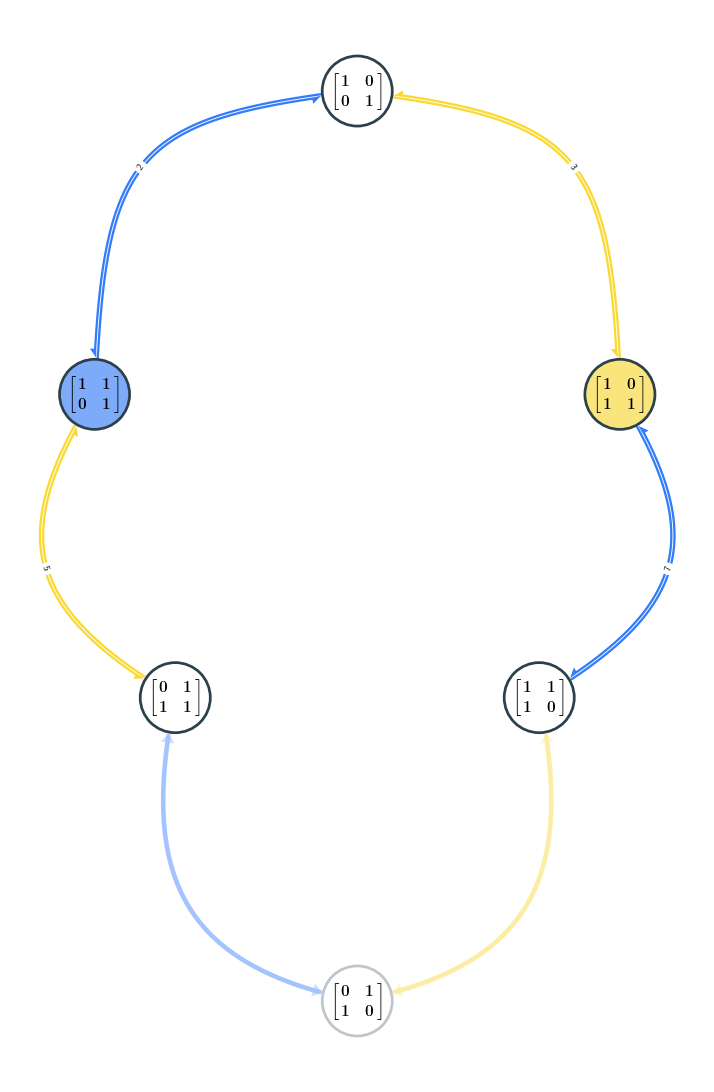

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
fig.set_dpi(70)
visualize_cayley_tree(5, fig, ax=ax, show_edge_labels=True);